In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

# import os
# if os.name == 'posix' :
#     plt.rc('font', family='AppleGothic')
# else :
#     plt.rc('font', family='Malgun Gothic')
    
plt.rc('axes', unicode_minus=False)

plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
# 검정을 위해 필요한 라이브러리
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro

# 하위 지표 찾기

## 데이터 불러오기

### 통합 데이터 

In [3]:
master_df = pd.read_csv('./master_table_v6.csv')
master_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,sign_up_date,first_vote_date,first_point_use_date,first_point_use_amount,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,2023-04-19 15:10:56.560337,2023-05-02 22:42:05,2023-05-05 07:32:34,-300.0,0,13,15.0,2.0,22,9
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,2023-04-20 00:11:00.962160,2023-04-28 14:18:07,2023-04-30 06:49:01,-300.0,0,8,10.0,1.0,14,9
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,2023-04-21 14:02:03.764186,2023-05-02 23:42:03,2023-05-03 05:10:18,-300.0,0,11,11.0,0.0,23,1
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,2023-04-21 15:23:53.149852,2023-05-02 22:22:58,2023-05-03 02:56:17,-300.0,0,11,11.0,0.0,22,12
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,2023-04-22 00:10:16.615160,2023-05-02 22:33:49,2023-05-03 13:03:16,-300.0,0,10,11.0,0.0,22,6


In [4]:
master_df.columns

Index(['Unnamed: 0', 'user_id', 'total_votes', 'unique_days', 'first_vote',
       'last_vote', 'active_days', 'cohort_day', 'retention_day8', 'gender',
       'school_id', 'grade', 'group_id', 'votes_within_3d',
       'period_friend_count', 'retention_group', 'address', 'student_count',
       'school_type', 'firstquestion_id', 'first_question_text',
       'first_question_category', 'chosen_count', 'sign_up_date',
       'first_vote_date', 'first_point_use_date', 'first_point_use_amount',
       'vote_sameday_signup', 'days_to_vote', 'days_to_point',
       'days_to_point_after_vote', 'first_vote_hour',
       'first_voteday_question_count'],
      dtype='object')

## cohort

- 상위 25%
    - 날짜 :  04.30, 05.02, 05.09, 05.10, 05.12, 05.20, 05.21
    - 행 개수 : 18,795개
    - 인원 수 : 1,253명
- 하위 25%
    - 05.04, 05.05, 05.06, 05.15, 05.16, 05.17, 05.24
    - 행 개수 : 18,660개
    - 인원 수 : 1,244명

In [5]:
master_df['retention_group'].unique()

array(['top25', 'bottom25'], dtype=object)

In [6]:
### 상위
# 상위 25% 그룹 나누기
cohort_upper25_df = master_df[master_df['retention_group']=='top25']

# 상위 25%의 유저 id 리스트로 정리
upper25_user_list = list(cohort_upper25_df['user_id'].unique())


### 하위
# 하위 25% 그룹 나누기
cohort_lower25_df = master_df[master_df['retention_group']=='bottom25']

# 하위 25%의 유저 id 리스트로 정리
lower25_user_list = list(cohort_lower25_df['user_id'].unique())

In [7]:
# 각 코호트별 유저 수 확인해보기

print(f"리텐션 상위 25% 그룹 유저 수 : {len(upper25_user_list)}")
print(f"리텐션 하위 25% 그룹 유저 수 : {len(lower25_user_list)}")

리텐션 상위 25% 그룹 유저 수 : 1263
리텐션 하위 25% 그룹 유저 수 : 1244


---

## 25%로 나눈 cohort별 지표 비교해보기

### 중학생? 고등학생?

In [8]:
# 상위 25%
school_type_rate_upper25 = cohort_upper25_df['school_type'].value_counts().reset_index()
school_type_rate_upper25['rate'] = school_type_rate_upper25['count'] / len(lower25_user_list)
school_type_rate_upper25

,school_type,count,rate
0,H,813,0.653537
1,M,450,0.361736


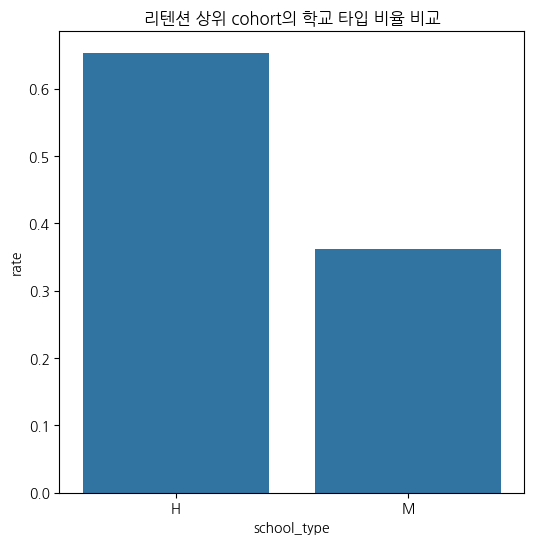

In [9]:
# 시각화
plt.figure(figsize=(6,6))
sns.barplot(data=school_type_rate_upper25, x='school_type', y='rate')
plt.title('리텐션 상위 cohort의 학교 타입 비율 비교')
plt.show()

In [10]:
# 하위 25%
school_type_rate_lower25 = cohort_lower25_df['school_type'].value_counts().reset_index()
school_type_rate_lower25['rate'] = school_type_rate_lower25['count'] / len(upper25_user_list)
school_type_rate_lower25

,school_type,count,rate
0,H,1187,0.939826
1,M,57,0.045131


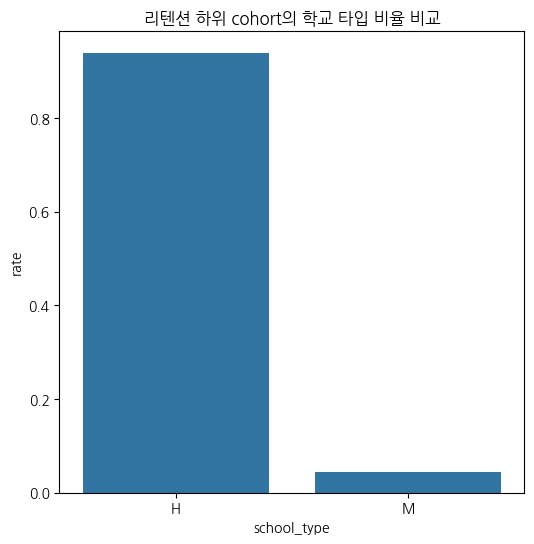

In [11]:
# 시각화
plt.figure(figsize=(6,6))
sns.barplot(data=school_type_rate_lower25, x='school_type', y='rate')
plt.title('리텐션 하위 cohort의 학교 타입 비율 비교')
plt.show()

### 마스터 테이블에 cohort 추가하기

In [12]:
# cohort 추가한 데이터프레임 만들기
master_cohort_df = master_df.copy()

# 상위 25% 유저는 1, 하위 25% 유저는 2, 아니면 결측값 넣기
master_cohort_df['cohort'] = master_cohort_df['user_id'].apply(
    lambda x : 1 if x in upper25_user_list
    else 2 if x in lower25_user_list
    else np.nan
)

master_cohort_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,first_vote_date,first_point_use_date,first_point_use_amount,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,cohort
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,2023-05-02 22:42:05,2023-05-05 07:32:34,-300.0,0,13,15.0,2.0,22,9,1
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,2023-04-28 14:18:07,2023-04-30 06:49:01,-300.0,0,8,10.0,1.0,14,9,1
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,2023-05-02 23:42:03,2023-05-03 05:10:18,-300.0,0,11,11.0,0.0,23,1,1
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,2023-05-02 22:22:58,2023-05-03 02:56:17,-300.0,0,11,11.0,0.0,22,12,1
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,2023-05-02 22:33:49,2023-05-03 13:03:16,-300.0,0,10,11.0,0.0,22,6,1


### 리텐션이 높은 집단에는 중학생이 더 많이 포함되어 있을 것이다
	•	귀무가설(H₀): 중학생 비율(cohort 1) ≤ 중학생 비율(cohort 2)
	•	대립가설(H₁): 중학생 비율(cohort 1) > 중학생 비율(cohort 2)
- 이 차이가 통계적으로 유의한가?이런 차이가 우연히 발생할 확률이 얼마나 되냐? 를 확인하기 위해서 통계 검정 진행
- 검정 방법 : "중학생은 리텐션 높은 집단에 더 많을 것이다”를 확인하기 위한 단측 검정 수행 ->  Z-test 

In [13]:
# 중학생 여부 컬럼 추가하기

# 원본 데이터 유지
master_cohort_middleschool_df = master_cohort_df.copy()

# 컬럼 추가
master_cohort_middleschool_df['middleschooler'] = master_cohort_middleschool_df['school_type'].apply(
    lambda x : 1 if x == 'M'
    else 0
)
master_cohort_middleschool_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,first_point_use_date,first_point_use_amount,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,cohort,middleschooler
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,2023-05-05 07:32:34,-300.0,0,13,15.0,2.0,22,9,1,0
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,2023-04-30 06:49:01,-300.0,0,8,10.0,1.0,14,9,1,0
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,2023-05-03 05:10:18,-300.0,0,11,11.0,0.0,23,1,1,0
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,2023-05-03 02:56:17,-300.0,0,11,11.0,0.0,22,12,1,0
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,2023-05-03 13:03:16,-300.0,0,10,11.0,0.0,22,6,1,0


In [14]:
master_cohort_middleschool_df.columns

Index(['Unnamed: 0', 'user_id', 'total_votes', 'unique_days', 'first_vote',
       'last_vote', 'active_days', 'cohort_day', 'retention_day8', 'gender',
       'school_id', 'grade', 'group_id', 'votes_within_3d',
       'period_friend_count', 'retention_group', 'address', 'student_count',
       'school_type', 'firstquestion_id', 'first_question_text',
       'first_question_category', 'chosen_count', 'sign_up_date',
       'first_vote_date', 'first_point_use_date', 'first_point_use_amount',
       'vote_sameday_signup', 'days_to_vote', 'days_to_point',
       'days_to_point_after_vote', 'first_vote_hour',
       'first_voteday_question_count', 'cohort', 'middleschooler'],
      dtype='object')

In [15]:
# 중학생 유저 id 뽑기
middleschool_user_list = list(master_cohort_middleschool_df[master_cohort_middleschool_df['middleschooler'] == 1]['user_id'].unique())

In [16]:
# cohort별로 중학생 수 세기
count_group1 = master_cohort_middleschool_df[(master_cohort_middleschool_df["cohort"] == 1) & (master_cohort_middleschool_df["middleschooler"] == 1)].shape[0]
count_group2 = master_cohort_middleschool_df[(master_cohort_middleschool_df["cohort"] == 2) & (master_cohort_middleschool_df["middleschooler"] == 1)].shape[0]

# cohort별 전체 수 세기
nobs_group1 = master_cohort_middleschool_df[master_cohort_middleschool_df["cohort"] == 1].shape[0]
nobs_group2 = master_cohort_middleschool_df[master_cohort_middleschool_df["cohort"] == 2].shape[0]

# proportions_ztest 실행 - 단측 검정 (group1이 더 클 것이라는 가정)
count = [count_group1, count_group2]
nobs = [nobs_group1, nobs_group2]

zstat, pval = proportions_ztest(count, nobs, alternative='larger')

print(f"Z-statistic: {zstat:.2f}")
print(f"p-value: {pval:.4f}")

if pval < 0.05:
    print("중학생 비율이 리텐션 높은 그룹(cohort 1)에서 유의하게 더 높습니다.")
else:
    print("중학생 비율 차이가 유의하지 않습니다.")

Z-statistic: 19.35
p-value: 0.0000
중학생 비율이 리텐션 높은 그룹(cohort 1)에서 유의하게 더 높습니다.


- zstat은 두 비율 차이가 얼마나 큰지 표준 정규 분포 기준으로 수치화한 값.
- 즉, zstat이 클수록 → p-value는 작아짐 → 귀무가설 기각 가능성 높아짐
```
중학생은 리텐션 높은 집단에 더 많음.
중학생의 참여를 높이자!
```

- cohort별 중학생 유저 리스트

In [17]:
upper25_middler_list = master_cohort_middleschool_df[(master_cohort_middleschool_df["cohort"] == 1) & (master_cohort_middleschool_df["middleschooler"] == 1)]['user_id'].unique()
lower25_middler_list = master_cohort_middleschool_df[(master_cohort_middleschool_df["cohort"] == 2) & (master_cohort_middleschool_df["middleschooler"] == 1)]['user_id'].unique()

---

#### 리텐션이 높았던 집단의 중학생과 낮은 집단의 중학생이 처음 접한 질문 카테고리에 차이가 있을까?

In [18]:
type(master_cohort_middleschool_df['first_question_category'].iloc[0])

str

In [19]:
master_cohort_middleschool_df['first_question_category'].iloc[0]

"['스타일']"

In [20]:
# 상위 25% 집단 중 중학생의 첫 질문 카테고리 가져오기

middleschool_firstquestion_category_upper25 = master_cohort_middleschool_df[(master_cohort_middleschool_df['cohort']==1)&(master_cohort_middleschool_df['middleschooler']==1)]

# 문자열을 리스트로 바꿔주는 함수
def parse_category_string(s):
    if isinstance(s, str):
        # 1. 대괄호 제거
        s = s.strip()[1:-1]
        # 2. 작은따옴표 제거
        s = s.replace("'", "")
        # 3. 공백 기준 split
        return s.split()
    return s

# 리스트로 변환
middleschool_firstquestion_category_upper25['first_question_category'] = (
    middleschool_firstquestion_category_upper25['first_question_category'].apply(parse_category_string)
)

# 카테고리 펼치기
middleschool_firstquestion_category_upper25 = middleschool_firstquestion_category_upper25.explode('first_question_category')
# 순위 확인해보기
middleschool_firstquestion_category_upper25['first_question_category'].value_counts()

/tmp/ipykernel_1342256/1816540209.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middleschool_firstquestion_category_upper25['first_question_category'] = (


first_question_category
인간관계    129
일상      121
스타일      45
연애       34
미래       29
성격       22
상상       20
지식       15
미디어      11
운동        9
심리        8
감성        7
Name: count, dtype: int64

In [21]:
# 하위 25% 집단 중 중학생의 첫 질문 카테고리 가져오기

middleschool_firstquestion_category_lower25 = master_cohort_middleschool_df[(master_cohort_middleschool_df['cohort']==2)&(master_cohort_middleschool_df['middleschooler']==1)]

# 문자열을 리스트로 바꿔주는 함수
def parse_category_string(s):
    if isinstance(s, str):
        # 1. 대괄호 제거
        s = s.strip()[1:-1]
        # 2. 작은따옴표 제거
        s = s.replace("'", "")
        # 3. 공백 기준 split
        return s.split()
    return s

# 리스트로 변환
middleschool_firstquestion_category_lower25['first_question_category'] = (
    middleschool_firstquestion_category_lower25['first_question_category'].apply(parse_category_string)
)
# 카테고리 펼치기
middleschool_firstquestion_category_lower25 = middleschool_firstquestion_category_lower25.explode('first_question_category')
# 순위 확인해보기
middleschool_firstquestion_category_lower25['first_question_category'].value_counts()

/tmp/ipykernel_1342256/2068301723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middleschool_firstquestion_category_lower25['first_question_category'] = (


first_question_category
일상      19
인간관계    16
연애       6
스타일      4
운동       3
미래       3
미디어      3
상상       2
지식       1
성격       1
Name: count, dtype: int64

- cohort별 참여한 모든 투표에 대해서 질문 카테고리 순위 확인해보기

In [22]:
# 질문 유형 정보 테이블
question_category_df = pd.read_parquet('./polls_question_add_one_category.parquet')
question_category_df.head()

,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,[상상]
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,[상상]
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,[미래]
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,[인간관계]
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,[인간관계]


In [23]:
# 투표 기록 테이블
userquestionrecord_df = pd.read_parquet('votes/accounts_userquestionrecord.parquet') 
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [24]:
# 질문id, user_id, category 함께 확인 가능하게 합치기

# 필요한 컬럼만 남기기
userquestionrecord_user_df = userquestionrecord_df[['created_at','user_id', 'question_id']]
question_category_user_df = question_category_df[['id', 'category']]
# merge
questionrecord_user_df = pd.merge(userquestionrecord_user_df, question_category_user_df, left_on='question_id', right_on='id', how='left')
# 중복컬럼 제거
questionrecord_user_df = questionrecord_user_df.drop(columns=['id'])
# 날짜 자르기
questionrecord_user_df = questionrecord_user_df[(questionrecord_user_df['created_at']>= '2023-04-28')&(questionrecord_user_df['created_at']<'2023-05-26')]
questionrecord_user_df.head()

,created_at,user_id,question_id,category
0,2023-04-28 12:27:49,849436,252,[스타일]
1,2023-04-28 12:28:02,849436,244,[인간관계]
2,2023-04-28 12:28:09,849436,183,[인간관계]
3,2023-04-28 12:28:16,849436,101,[미래]
4,2023-04-28 12:28:26,849436,209,[스타일]


In [25]:
# 상위 25% 집단 중 중학생의 데이터 분석 기간동안 투표한 질문 카테고리 확인하기

question_category_upper25 = questionrecord_user_df[questionrecord_user_df['user_id'].isin(upper25_middler_list)]

# 문자열을 리스트로 바꿔주는 함수
def parse_category_string(s):
    if isinstance(s, str):
        # 1. 대괄호 제거
        s = s.strip()[1:-1]
        # 2. 작은따옴표 제거
        s = s.replace("'", "")
        # 3. 공백 기준 split
        return s.split()
    return s

# 리스트로 변환
question_category_upper25['category'] = (
    question_category_upper25['category'].apply(parse_category_string)
)

# 카테고리 펼치기
question_category_upper25 = question_category_upper25.explode('category')
# 순위 확인해보기
question_category_upper25['category'].value_counts()

/tmp/ipykernel_1342256/3186568979.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_category_upper25['category'] = (


category
인간관계    34335
일상      27519
스타일     12500
연애       9616
성격       6543
미래       6029
상상       6003
지식       3862
미디어      2606
심리       2366
운동       2214
감성       1970
Name: count, dtype: int64

In [26]:
# 하위 25% 집단 중 중학생의 데이터 분석 기간동안 투표한 질문 카테고리 확인하기

question_category_lower25 = questionrecord_user_df[questionrecord_user_df['user_id'].isin(lower25_middler_list)]

# 문자열을 리스트로 바꿔주는 함수
def parse_category_string(s):
    if isinstance(s, str):
        # 1. 대괄호 제거
        s = s.strip()[1:-1]
        # 2. 작은따옴표 제거
        s = s.replace("'", "")
        # 3. 공백 기준 split
        return s.split()
    return s

# 리스트로 변환
question_category_lower25['category'] = (
    question_category_lower25['category'].apply(parse_category_string)
)

# 카테고리 펼치기
question_category_lower25 = question_category_lower25.explode('category')
# 순위 확인해보기
question_category_lower25['category'].value_counts()

/tmp/ipykernel_1342256/3501898772.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_category_lower25['category'] = (


category
인간관계    2244
일상      1956
스타일      896
연애       628
성격       389
상상       342
미래       289
미디어      229
지식       171
운동       152
심리       107
감성       106
Name: count, dtype: int64

- cohort 상관없이 비슷한 카테고리의 질문에 투표를 많이함. 
- 전체 유저 편리성을 위해서 질문 카테고리를 선택할 수 있게 해주는건?

In [27]:
# 생성된 질문의 카테고리 수 확인해보기

# 펼치기
question_category_explode_df = question_category_df.explode('category')
# 카테고리 내림차순
question_category_explode_df['category'].value_counts()

category
일상      1466
인간관계    1401
스타일      618
연애       404
상상       268
성격       205
미래       170
미디어      164
지식       124
운동       116
심리        80
감성        68
Name: count, dtype: int64

---

- 그렇다면? 중학생만이 아니라 전체 유저도 확인해보기

In [28]:
# 상위 25% 집단 중 데이터 분석 기간동안 투표한 질문 카테고리 확인하기

question_category_upper25 = questionrecord_user_df[questionrecord_user_df['user_id'].isin(upper25_user_list)]

# 문자열을 리스트로 바꿔주는 함수
def parse_category_string(s):
    if isinstance(s, str):
        # 1. 대괄호 제거
        s = s.strip()[1:-1]
        # 2. 작은따옴표 제거
        s = s.replace("'", "")
        # 3. 공백 기준 split
        return s.split()
    return s

# 리스트로 변환
question_category_upper25['category'] = (
    question_category_upper25['category'].apply(parse_category_string)
)

# 카테고리 펼치기
question_category_upper25 = question_category_upper25.explode('category')
# 순위 확인해보기
question_category_upper25['category'].value_counts()

/tmp/ipykernel_1342256/2813701525.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_category_upper25['category'] = (


category
인간관계    95074
일상      73819
스타일     34271
연애      24940
성격      17547
미래      16696
상상      16163
지식      11137
미디어      7106
심리       6202
운동       5873
감성       5180
Name: count, dtype: int64

In [29]:
# 하위 25% 집단 중 중학생의 데이터 분석 기간동안 투표한 질문 카테고리 확인하기

question_category_lower25 = questionrecord_user_df[questionrecord_user_df['user_id'].isin(lower25_user_list)]

# 문자열을 리스트로 바꿔주는 함수
def parse_category_string(s):
    if isinstance(s, str):
        # 1. 대괄호 제거
        s = s.strip()[1:-1]
        # 2. 작은따옴표 제거
        s = s.replace("'", "")
        # 3. 공백 기준 split
        return s.split()
    return s

# 리스트로 변환
question_category_lower25['category'] = (
    question_category_lower25['category'].apply(parse_category_string)
)

# 카테고리 펼치기
question_category_lower25 = question_category_lower25.explode('category')
# 순위 확인해보기
question_category_lower25['category'].value_counts()

/tmp/ipykernel_1342256/3861168031.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_category_lower25['category'] = (


category
인간관계    68592
일상      53444
스타일     25391
연애      17988
성격      13270
미래      12881
상상      12318
지식       8682
미디어      4873
심리       4813
운동       4497
감성       4331
Name: count, dtype: int64

- 해당 카테고리의 질문이 많아서 그랬던건 아닐까?
- 카테고리별 비중이 비슷한데도 저렇게 순위가 나뉜걸까?

---

#### 리텐션이 높았던 집단의 중학생과 낮은 집단의 중학생 사이 첫 투표 시간대에 차이가 있을까??

In [30]:
# 첫 투표 시간대 확인하기

# 투표 기록 테이블에서 기간 4/28 ~ 7/31 자르기
userquestionrecord_hour_df = userquestionrecord_df[(userquestionrecord_df['created_at']>='2023-04-28')&(userquestionrecord_df['created_at']<'2023-08-01')]

# 날짜, 유저id만 남기기
userquestionrecord_hour_df = userquestionrecord_hour_df[['created_at', 'user_id']]

# 유저별 첫 투표 일자만 남기기
userquestionrecord_hour_df = userquestionrecord_hour_df.groupby(['user_id'])['created_at'].first().reset_index()

# 시간 컬럼 생성
userquestionrecord_hour_df['hour'] = userquestionrecord_hour_df['created_at'].dt.hour

userquestionrecord_hour_df.head()

,user_id,created_at,hour
0,838023,2023-04-29 16:22:56,16
1,838466,2023-05-02 22:42:05,22
2,838642,2023-04-28 14:18:07,14
3,839357,2023-04-29 16:51:01,16
4,840293,2023-05-03 02:24:05,2


In [31]:
# 최종 테이블에 합치기
master_cohort_middleschool_df = pd.merge(master_cohort_middleschool_df, userquestionrecord_hour_df, on='user_id', how='left')
master_cohort_middleschool_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,cohort,middleschooler,created_at,hour
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,0,13,15.0,2.0,22,9,1,0,2023-05-02 22:42:05,22
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,0,8,10.0,1.0,14,9,1,0,2023-04-28 14:18:07,14
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,0,11,11.0,0.0,23,1,1,0,2023-05-02 23:42:03,23
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,0,11,11.0,0.0,22,12,1,0,2023-05-02 22:22:58,22
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,0,10,11.0,0.0,22,6,1,0,2023-05-02 22:33:49,22


In [32]:
# 상위 25% 집단 중 중학생
middleschool_upper25 = master_cohort_middleschool_df[(master_cohort_middleschool_df['cohort']==1)&(master_cohort_middleschool_df['middleschooler']==1)]

# 하위 25% 집단 중 중학생
middleschool_lower25 = master_cohort_middleschool_df[(master_cohort_middleschool_df['cohort']==2)&(master_cohort_middleschool_df['middleschooler']==1)]


- cohort별 서비스 사용(투표한) 평균 시간 확인해보기

In [33]:
# 중학생 상위 25%의 이용 시간 확인하기
middleschool_upper25['hour'].value_counts()

hour
9     65
10    43
11    43
12    43
8     41
14    40
13    39
15    30
7     21
6     20
23    16
4     15
22    12
16    10
5      6
3      4
21     1
18     1
Name: count, dtype: int64

In [34]:
# 중학생 하위 25%의 이용 시간 확인하기
middleschool_lower25['hour'].value_counts()

hour
13    10
10     6
8      6
6      5
11     5
9      5
7      4
5      3
12     3
15     2
23     2
4      2
14     1
17     1
16     1
3      1
Name: count, dtype: int64

---

#### 리텐션이 높았던 집단의 중학생과 낮은 집단의 중학생 사이 투표받은 수는 차이가 있을까??

In [35]:
middleschool_upper25['chosen_count'].isna().sum()

0

In [36]:
middleschool_lower25['chosen_count'].isna().sum()

0

In [37]:
# t-test
group1 = master_cohort_middleschool_df[(master_cohort_middleschool_df['cohort']==1)&(master_cohort_middleschool_df['middleschooler']==1)]['chosen_count']
group2 = master_cohort_middleschool_df[(master_cohort_middleschool_df['cohort']==2)&(master_cohort_middleschool_df['middleschooler']==1)]['chosen_count']

# 결측값 제거 
group1 = group1.dropna()
group2 = group2.dropna()

# Welch's t-test (비등분산)
tstat, pval = ttest_ind(group1, group2, equal_var=False)
print(f"[Welch's t-test] t-stat: {tstat:.3f}, p-value: {pval:.4f}")

# Mann-Whitney U test (비모수)
u_stat, pval_u = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"[Mann-Whitney U] U-stat: {u_stat:.3f}, p-value: {pval_u:.4f}")

[Welch's t-test] t-stat: 15.551, p-value: 0.0000
[Mann-Whitney U] U-stat: 22281.000, p-value: 0.0000


In [38]:
group1.mean()

320.81333333333333

In [39]:
group2.mean()

109.54385964912281

- Welch’s t-test는 평균을 비교하는 검정이므로: “cohort 1과 2의 chosen_count 평균이 유의미하게 다르다”고 해석.
- Mann-Whitney U test는 분포(특히 중위수)를 비교하는 비모수 검정이므로: “cohort 1과 2의 chosen_count 중앙값 또는 전체 분포가 유의미하게 다르다”고 해석.

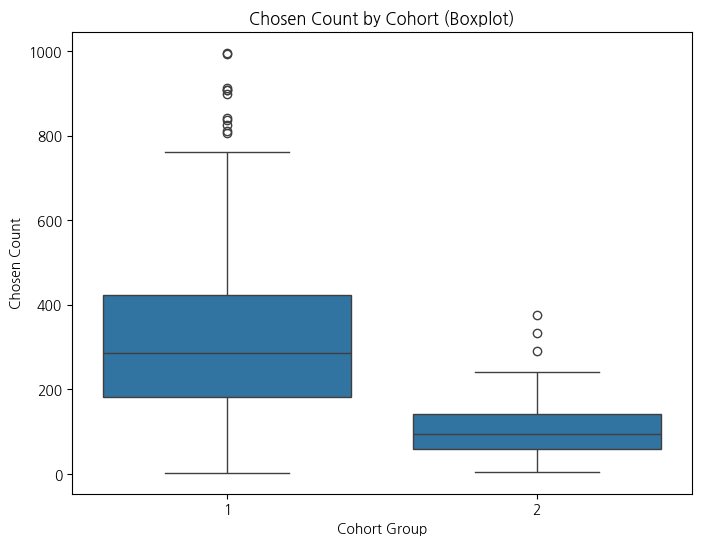

In [40]:
# 시각화

# 중학생 데이만 남기기
middleschool_df = master_cohort_middleschool_df[master_cohort_middleschool_df['middleschooler']==1]
# 박스플롯
plt.figure(figsize=(8, 6))
sns.boxplot(x='cohort', y='chosen_count', data=middleschool_df)
plt.title('Chosen Count by Cohort (Boxplot)')
plt.xlabel('Cohort Group')
plt.ylabel('Chosen Count')
plt.show()

- 리텐션이 높은 집단은 당연하게 사용 기간이 기니까 투표 받은것도 많지 않은가??
- 그렇다면 사용 일자 대비 받은 투표수를 확인해보자!

In [41]:
middleschool_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,cohort,middleschooler,created_at,hour
938,938,899988,420,27,2023-05-17,2023-07-19,63,2023-05-17,0.275362,M,...,0,10,10.0,-1.0,6,25,2,1,2023-05-17 06:23:27,6
1000,1000,918489,159,7,2023-05-12,2023-05-27,15,2023-05-12,0.529032,F,...,0,5,5.0,0.0,9,25,1,1,2023-05-12 09:54:06,9
1004,1004,922680,1001,30,2023-05-09,2023-07-08,60,2023-05-09,0.731602,F,...,0,2,3.0,1.0,8,67,1,1,2023-05-09 08:52:39,8
1007,1007,924006,166,11,2023-05-09,2023-05-29,20,2023-05-09,0.731602,F,...,0,2,2.0,0.0,8,22,1,1,2023-05-09 08:47:23,8
1021,1021,928814,640,24,2023-05-09,2023-07-20,72,2023-05-09,0.731602,F,...,0,2,6.0,3.0,8,40,1,1,2023-05-09 08:48:12,8


In [42]:
middleschool_df['active_days'].describe()

count    507.000000
mean      27.794872
std       17.617627
min        0.000000
25%       15.000000
50%       25.000000
75%       36.000000
max       82.000000
Name: active_days, dtype: float64

/tmp/ipykernel_1342256/3412071390.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middleschool_df['active_days'] = middleschool_df['active_days'] + 1
/tmp/ipykernel_1342256/3412071390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middleschool_df['vote_acquisition_rate'] = middleschool_df['chosen_count'] / middleschool_df['active_days']


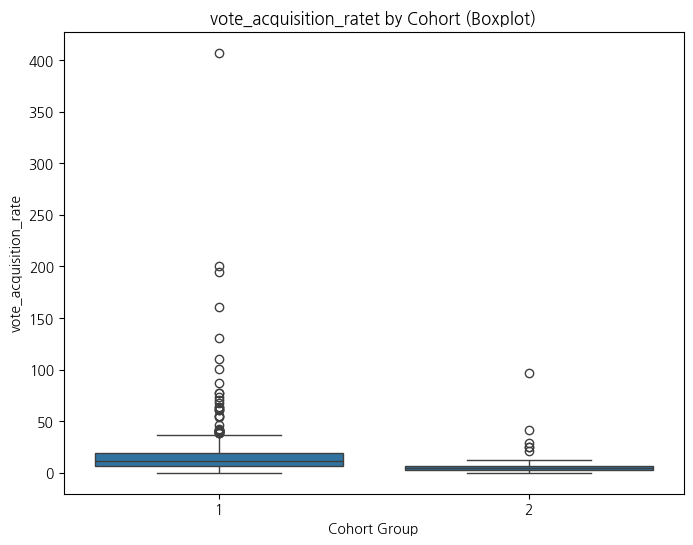

In [43]:
# 일별 투표 획득률 vote_acquisition_rate = chosen_count(받은 투표) / active_days (활동 기간)

# active_days = last_vote - first_vote
# 이렇게 되면 사용한 날짜 중 하루가 빠지게됨
# ex ) 첫 날 투표하고 다시 투표한적이 없는 경우 1일이 아니라 0일로 됨
# active_days + 1 하기로 결정

middleschool_df['active_days'] = middleschool_df['active_days'] + 1

# 중학생 데이터에서 일별 투표 획득률 뽑아보기
middleschool_df['vote_acquisition_rate'] = middleschool_df['chosen_count'] / middleschool_df['active_days']

# 박스플롯
plt.figure(figsize=(8, 6))
sns.boxplot(x='cohort', y='vote_acquisition_rate', data=middleschool_df)
plt.title('vote_acquisition_ratet by Cohort (Boxplot)')
plt.xlabel('Cohort Group')
plt.ylabel('vote_acquisition_rate')
plt.show()


In [44]:
# 중학생 데이터에서 투표 획득률 뽑아보기
middleschool_df['vote_acquisition_rate']

938      5.203125
1000    14.687500
1004    12.196721
1007    31.142857
1021     8.657534
          ...    
2468     3.615385
2482    41.000000
2485     2.777778
2494     0.937500
2496     2.350000
Name: vote_acquisition_rate, Length: 507, dtype: float64

In [45]:
# 일별 투표 획득률이 통계적으로 유의한지 검정하기 위해서 정규성 검정

# 두 집단으로 나누기
group1 = middleschool_df[(middleschool_df['cohort']==1)]['vote_acquisition_rate']
group2 = middleschool_df[(middleschool_df['cohort']==2)]['vote_acquisition_rate']

# 결측값 제거 
group1 = group1.dropna()
group2 = group2.dropna()

print("Group1:", shapiro(group1))
print("Group2:", shapiro(group2))

Group1: ShapiroResult(statistic=0.4161464987714417, pvalue=1.220705500513939e-35)
Group2: ShapiroResult(statistic=0.45757770242094786, pvalue=3.383638840974255e-13)


In [46]:
# t-test

# Welch's t-test (비등분산)
tstat, pval = ttest_ind(group1, group2, equal_var=False)
print(f"[Welch's t-test] t-stat: {tstat:.3f}, p-value: {pval:.4f}")

# Mann-Whitney U test (비모수)
u_stat, pval_u = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"[Mann-Whitney U] U-stat: {u_stat:.3f}, p-value: {pval_u:.4f}")

[Welch's t-test] t-stat: 4.126, p-value: 0.0001
[Mann-Whitney U] U-stat: 19799.500, p-value: 0.0000


- 통계적으로 유의한 차이

In [47]:
print(len(group1), len(group2))
print(group1.describe())
print(group2.describe())

450 57
count    450.000000
mean      17.573497
std       27.759190
min        0.041667
25%        6.612772
50%       11.518590
75%       18.923077
max      407.000000
Name: vote_acquisition_rate, dtype: float64
count    57.000000
mean      8.129761
std      14.178476
min       0.133333
25%       2.434783
50%       4.875000
75%       6.833333
max      97.000000
Name: vote_acquisition_rate, dtype: float64


- 리텐션 상위 25% cohort의 일평균 받은 투표 수 : 약 17.573
- 리텐션 하위 25% cohort의 일평균 받은 투표 수 : 약 8.129

---

- 중학생 유저들의 지역 확인하기

In [48]:
master_cohort_middleschool_df.columns

Index(['Unnamed: 0', 'user_id', 'total_votes', 'unique_days', 'first_vote',
       'last_vote', 'active_days', 'cohort_day', 'retention_day8', 'gender',
       'school_id', 'grade', 'group_id', 'votes_within_3d',
       'period_friend_count', 'retention_group', 'address', 'student_count',
       'school_type', 'firstquestion_id', 'first_question_text',
       'first_question_category', 'chosen_count', 'sign_up_date',
       'first_vote_date', 'first_point_use_date', 'first_point_use_amount',
       'vote_sameday_signup', 'days_to_vote', 'days_to_point',
       'days_to_point_after_vote', 'first_vote_hour',
       'first_voteday_question_count', 'cohort', 'middleschooler',
       'created_at', 'hour'],
      dtype='object')

In [49]:
master_cohort_middleschool_df['address'].unique()

array(['충청남도 아산시', '충청남도 천안시 서북구', '경기도 광주시', '경기도 화성시', '경상남도 거제시',
       '경기도 광명시', '인천광역시 서구', '경기도 남양주시', '울산광역시 울주군'], dtype=object)

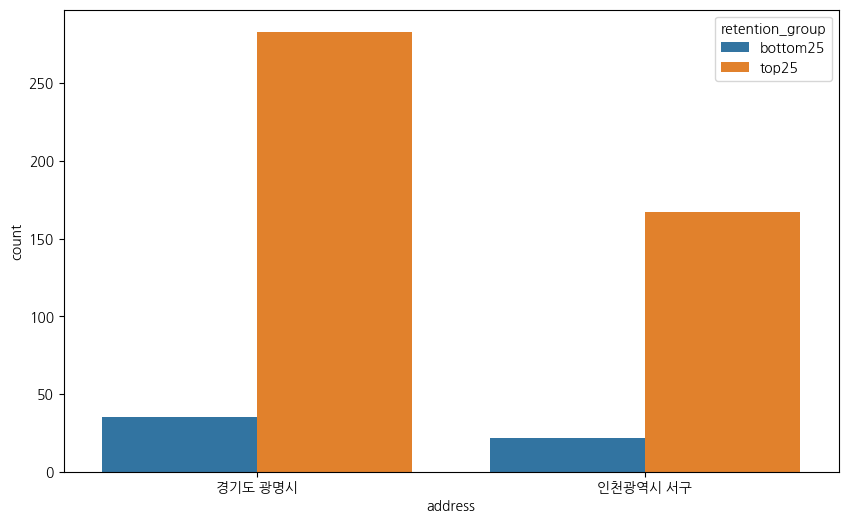

In [50]:
# 중학생 데이터
middleschooler_df = master_cohort_middleschool_df[master_cohort_middleschool_df['middleschooler'] == 1]

# 시각화 해보기
plt.figure(figsize=(10,6))
sns.countplot(data=middleschooler_df, x='address', hue='retention_group')
plt.show()

---

- 중학생 유저들의 성별 확인

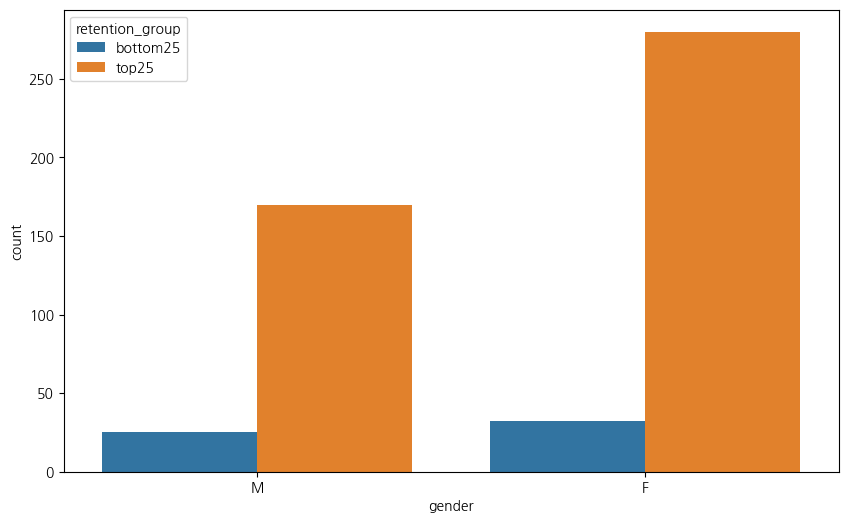

In [51]:
# 시각화 해보기
plt.figure(figsize=(10,6))
sns.countplot(data=middleschooler_df, x='gender', hue='retention_group')
plt.show()

---

- 중학생들의 알람 on 여부 확인

In [52]:
user_df = pd.read_parquet('./votes/accounts_user.parquet')
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [53]:
# 중학생들 데이터만 뽑기
user_push_df = user_df[user_df['id'].isin(middleschool_user_list)]

# 필요 컬럼만 뽑기
user_push_df = user_push_df[['id', 'is_push_on']]

In [54]:
user_push_df['is_push_on'].value_counts()

is_push_on
1    451
0     56
Name: count, dtype: int64

- 'first_point_use_date'
- 'first_point_use_amount',
- 'vote_sameday_signup'
- 'days_to_vote'
- 'days_to_point',
- 'days_to_point_after_vote'
- 'first_vote_hour'
- 'first_voteday_question_count

In [55]:
middleschool_df.head()

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,cohort,middleschooler,created_at,hour,vote_acquisition_rate
938,938,899988,420,27,2023-05-17,2023-07-19,64,2023-05-17,0.275362,M,...,10,10.0,-1.0,6,25,2,1,2023-05-17 06:23:27,6,5.203125
1000,1000,918489,159,7,2023-05-12,2023-05-27,16,2023-05-12,0.529032,F,...,5,5.0,0.0,9,25,1,1,2023-05-12 09:54:06,9,14.687500
1004,1004,922680,1001,30,2023-05-09,2023-07-08,61,2023-05-09,0.731602,F,...,2,3.0,1.0,8,67,1,1,2023-05-09 08:52:39,8,12.196721
1007,1007,924006,166,11,2023-05-09,2023-05-29,21,2023-05-09,0.731602,F,...,2,2.0,0.0,8,22,1,1,2023-05-09 08:47:23,8,31.142857
1021,1021,928814,640,24,2023-05-09,2023-07-20,73,2023-05-09,0.731602,F,...,2,6.0,3.0,8,40,1,1,2023-05-09 08:48:12,8,8.657534


In [56]:
# 중학생 리텐션 상위/하위 집단 데이터
middleschool_df['days_to_point'].value_counts()

days_to_point
0.0     339
1.0      73
2.0      36
3.0      15
5.0       6
7.0       6
4.0       6
6.0       5
10.0      4
9.0       2
71.0      1
11.0      1
75.0      1
12.0      1
Name: count, dtype: int64

In [57]:
middleschool_df.groupby(['retention_group'])['first_point_use_amount'].mean()

retention_group
bottom25   -249.038462
top25      -272.454955
Name: first_point_use_amount, dtype: float64

In [58]:
middleschool_df.groupby(['retention_group'])['vote_sameday_signup'].mean()

retention_group
bottom25    0.771930
top25       0.766667
Name: vote_sameday_signup, dtype: float64

In [59]:
middleschool_df.groupby(['retention_group'])['days_to_point'].mean()

retention_group
bottom25    3.019231
top25       0.869369
Name: days_to_point, dtype: float64

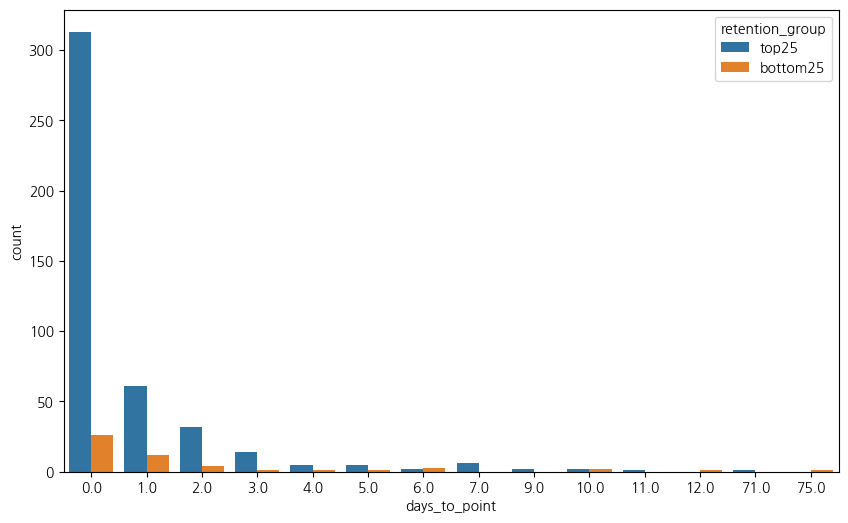

In [60]:
plt.figure(figsize=(10,6))
sns.countplot(data=middleschool_df, x='days_to_point', hue='retention_group')
plt.show()

- 리텐션이 높은 집단이 낮은 집단과 차이나는 점
    - 가입 당일에 포인트 사용 비중이 높음.
    - 중학생 프로모션으로 회원가입 즉시 포인트 사용 유도

In [ ]:
# 회원가입부터 첫 포인트 사용일까지의 기간이 통계적으로 유의한지 검정하기 위해서 정규성 검정

# 두 집단으로 나누기
group1 = middleschool_df[(middleschool_df['retention_group']=='top25')]['days_to_point']
group2 = middleschool_df[(middleschool_df['retention_group']=='bottom25')]['days_to_point']

# 결측값 제거 
group1 = group1.dropna()
group2 = group2.dropna()

print("Group1:", shapiro(group1))
print("Group2:", shapiro(group2))

Group1: ShapiroResult(statistic=0.19120095306518503, pvalue=8.71169475062546e-40)
Group2: ShapiroResult(statistic=0.27515399146515895, pvalue=1.3754137986985716e-14)


- 두 그룹은 정규분포가 아님. 평균을 비교할 경우 비모수 검정 사용 진행

In [63]:
# t-test

# Mann-Whitney U test (비모수)
u_stat, pval_u = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"[Mann-Whitney U] U-stat: {u_stat:.3f}, p-value: {pval_u:.4f}")

[Mann-Whitney U] U-stat: 9012.000, p-value: 0.0017


In [64]:
print(len(group1), len(group2))
print(group1.describe())
print(group2.describe())

444 52
count    444.000000
mean       0.869369
std        3.702974
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       71.000000
Name: days_to_point, dtype: float64
count    52.000000
mean      3.019231
std      10.554230
min       0.000000
25%       0.000000
50%       0.500000
75%       2.000000
max      75.000000
Name: days_to_point, dtype: float64
